In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  report = classification_report(y_true, y_pred)
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  y_train_pred = model.predict(X_train)
  results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  y_test_pred = model.predict(X_test)
  results_test = classification_metrics(y_test, y_test_pred,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
df = pd.read_csv('Data/Car_Insurance_Claim.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
df.tail()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
9995,323164,26-39,female,majority,10-19y,university,upper class,0.582787,1.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,1,0.0
9996,910346,26-39,female,majority,10-19y,none,middle class,0.522231,1.0,after 2015,0.0,1.0,32765,NaN,sedan,1,0,0,0.0
9997,468409,26-39,male,majority,0-9y,high school,middle class,0.470940,1.0,before 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,0.0
9998,903459,26-39,female,majority,10-19y,high school,poverty,0.364185,0.0,before 2015,0.0,1.0,10238,13000.0,sedan,2,0,1,1.0
9999,442696,26-39,female,majority,0-9y,none,working class,0.435225,1.0,before 2015,1.0,1.0,10238,13000.0,sedan,0,0,0,0.0


In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [7]:
df['MARRIED'] = df['MARRIED'].astype(int)
df['MARRIED'].dtypes

dtype('int32')

In [8]:
df['CHILDREN'] = df['CHILDREN'].astype(int)
df['CHILDREN'].dtypes

dtype('int32')

In [9]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


In [10]:
df.describe(exclude='number')

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,4,2,2,4,3,4,2,2
top,26-39,female,majority,0-9y,high school,upper class,before 2015,sedan
freq,3063,5010,9012,3530,4157,4336,6967,9523


In [11]:
corr = df.corr(numeric_only=True)

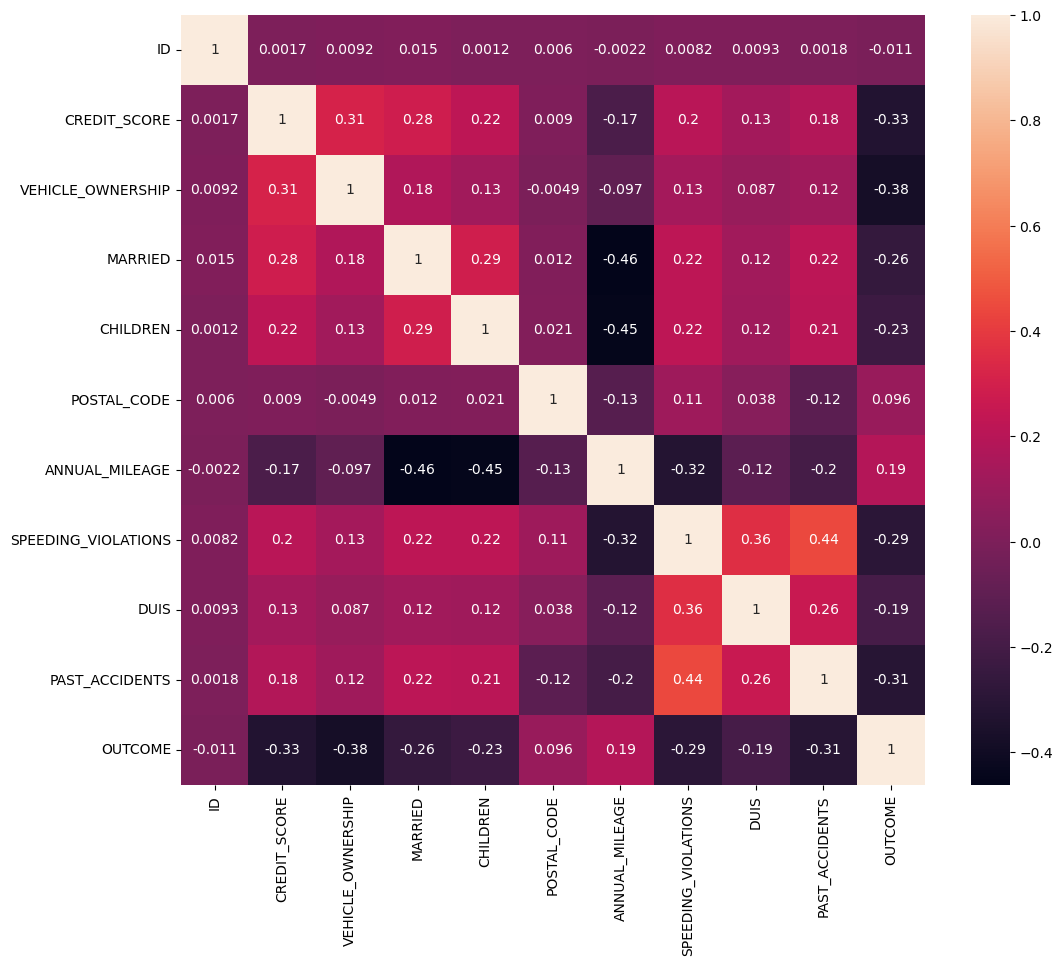

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True, ax=ax);

- Our data does not have features correlated to the target.

<Axes: >

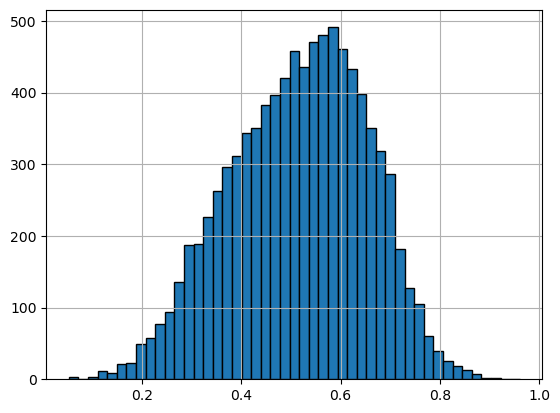

In [13]:
df['CREDIT_SCORE'].hist(bins='auto', edgecolor='black')

- The average credit score of our customers falls just under 600.

In [14]:
df['OUTCOME'].value_counts(normalize=True)

0.0    0.6867
1.0    0.3133
Name: OUTCOME, dtype: float64

In [15]:
X = df.drop(columns=['OUTCOME'])
y = df['OUTCOME']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
y_train.value_counts(normalize=True)

0.0    0.685867
1.0    0.314133
Name: OUTCOME, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0.0    0.6892
1.0    0.3108
Name: OUTCOME, dtype: float64

In [18]:
df['EDUCATION'].value_counts()

high school    4157
university     3928
none           1915
Name: EDUCATION, dtype: int64

In [19]:
df['INCOME'].value_counts()

upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: INCOME, dtype: int64

In [20]:
df['AGE'].value_counts()

26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: AGE, dtype: int64

In [21]:
ord_cols = ['EDUCATION', 'INCOME', 'AGE']
ord_cols

['EDUCATION', 'INCOME', 'AGE']

In [22]:
age_order = ['16-25', '26-39', '40-64', '65+']
education_order = ['none', 'high school', 'university']
income_order = ['poverty', 'working class', 'middle class', 'upper class']
ord_orders = [education_order, income_order, age_order]
ord_encoder = OrdinalEncoder(categories=ord_orders)
scaler = StandardScaler()
ord_pipe = make_pipeline(ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['none', 'high school',
                                             'university'],
                                            ['poverty', 'working class',
                                             'middle class', 'upper class'],
                                            ['16-25', '26-39', '40-64',
                                             '65+']])),
                ('standardscaler', StandardScaler())])

In [23]:
ord_tuple = ('Ordinal', ord_pipe, ord_cols)

In [24]:
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')

In [25]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [26]:
ohe_tuple = ('Categorical', ohe_pipe, cat_cols)

In [27]:
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')

In [28]:
impute_median = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [29]:
num_tuple = ('Numeric', num_pipe, num_cols)

In [30]:
col_trans = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
col_trans

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('Ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEnco...
                                                                              'upper '
                                                                              'class'],
                                                                             ['16-25',
                                                                              '26-39',
                                                                              '40-64',
                                                                              '65+']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['EDUCATION', 'INCOME', 'AGE']),
                                ('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object'))],
                  verbose_feature_names_out=False)

In [31]:
X_train_proc = col_trans.fit_transform(X_train)
X_test_proc = col_trans.transform(X_test)

In [32]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_proc, y_train)

LogisticRegression(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      5144
         1.0       0.77      0.72      0.75      2356

    accuracy                           0.84      7500
   macro avg       0.82      0.81      0.82      7500
weighted avg       0.84      0.84      0.84      7500



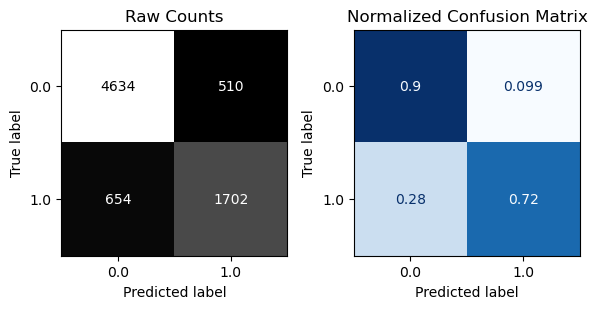


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1723
         1.0       0.76      0.71      0.74       777

    accuracy                           0.84      2500
   macro avg       0.82      0.81      0.81      2500
weighted avg       0.84      0.84      0.84      2500



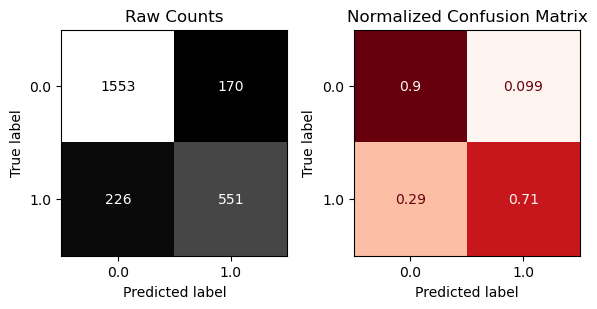

In [33]:
evaluate_classification(log_reg, X_train_proc, y_train, X_test_proc, y_test)

In [34]:
importances = permutation_importance(log_reg, X_test_proc, y_test, n_repeats=5, random_state=42)
importances.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [35]:
permutation_importances = pd.Series(importances['importances_mean'],index=X_test_proc.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

DRIVING_EXPERIENCE_0-9y      0.10320
VEHICLE_OWNERSHIP            0.04536
VEHICLE_YEAR_before 2015     0.01512
VEHICLE_YEAR_after 2015      0.01512
DRIVING_EXPERIENCE_20-29y    0.00896
DRIVING_EXPERIENCE_30y+      0.00888
POSTAL_CODE                  0.00800
DRIVING_EXPERIENCE_10-19y    0.00616
GENDER_female                0.00560
GENDER_male                  0.00560
MARRIED                      0.00448
PAST_ACCIDENTS               0.00392
CHILDREN                     0.00360
ANNUAL_MILEAGE               0.00160
AGE                          0.00064
EDUCATION                    0.00064
ID                           0.00008
VEHICLE_TYPE_sedan           0.00000
VEHICLE_TYPE_sports car      0.00000
INCOME                      -0.00024
RACE_minority               -0.00032
RACE_majority               -0.00032
CREDIT_SCORE                -0.00048
DUIS                        -0.00048
SPEEDING_VIOLATIONS         -0.00280
Name: permutation importance, dtype: float64

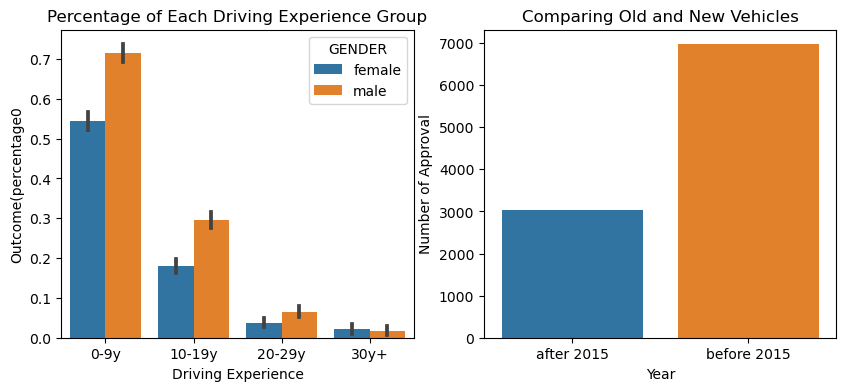

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
sns.barplot(data=df, hue='GENDER', x = 'DRIVING_EXPERIENCE', y = 'OUTCOME', ax=axes[0])
axes[0].set_title('Percentage of Each Driving Experience Group', fontsize = 12)
axes[0].set_ylabel("Outcome(percentage0")
axes[0].set_xlabel("Driving Experience")
# Subplot 2
sns.countplot(data=df, x='VEHICLE_YEAR', ax=axes[1])
axes[1].set_title('Comparing Old and New Vehicles', fontsize = 12)
axes[1].set_ylabel("Number of Approval")
axes[1].set_xlabel("Year");

- Most of the people getting approved for insurance are young male drivers.
- We can also see that individuals with old model cars have a higher chance of getting approved.